# Predicting `Outstate` in `College` dataset with FSS and GAM

## Preparing the data

A description of the dataset can be [found here](https://cran.r-project.org/web/packages/ISLR/ISLR.pdf)

In [185]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style('whitegrid')
import matplotlib.pyplot as plt

college = pd.read_csv('../../datasets/College.csv')
college = college.rename({'Unnamed: 0': 'Name'}, axis=1)
college.head()


,Name,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [186]:
college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
Name           777 non-null object
Private        777 non-null object
Apps           777 non-null int64
Accept         777 non-null int64
Enroll         777 non-null int64
Top10perc      777 non-null int64
Top25perc      777 non-null int64
F.Undergrad    777 non-null int64
P.Undergrad    777 non-null int64
Outstate       777 non-null int64
Room.Board     777 non-null int64
Books          777 non-null int64
Personal       777 non-null int64
PhD            777 non-null int64
Terminal       777 non-null int64
S.F.Ratio      777 non-null float64
perc.alumni    777 non-null int64
Expend         777 non-null int64
Grad.Rate      777 non-null int64
dtypes: float64(1), int64(16), object(2)
memory usage: 115.4+ KB


In [187]:
# dummy variables for categorical variables
data = pd.concat([college['Name'], 
                     pd.get_dummies(college.drop(columns=['Name']))], 
                    axis=1)
# drop redundant variable
data = data.drop(columns=['Private_Yes'])

# standardize
cols = data.columns.drop(['Name', 'Private_No'])
df = data[cols]
data.loc[:, list(cols)] = (df - df.mean())/df.std()
data.head()

,Name,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_No
0,Abilene Christian University,-0.346659,-0.320999,-0.063468,-0.258416,-0.191704,-0.168008,-0.209072,-0.745875,-0.964284,-0.601924,1.269228,-0.162923,-0.115654,1.013123,-0.867016,-0.501587,-0.318047,0
1,Adelphi University,-0.210748,-0.038678,-0.288398,-0.655234,-1.353040,-0.209653,0.244150,0.457202,1.907979,1.215097,0.235363,-2.673923,-3.376001,-0.477397,-0.544222,0.166003,-0.550907,0
2,Adrian College,-0.406604,-0.376076,-0.477814,-0.315105,-0.292690,-0.549212,-0.496770,0.201175,-0.553960,-0.904761,-0.259415,-1.204069,-0.930741,-0.300556,0.585558,-0.177176,-0.667337,0
3,Agnes Scott College,-0.667830,-0.681243,-0.691982,1.839046,1.676532,-0.657656,-0.520416,0.626229,0.996150,-0.601924,-0.687730,1.184443,1.174900,-1.614235,1.150447,1.791697,-0.376262,0
4,Alaska Pacific University,-0.725709,-0.764063,-0.780232,-0.655234,-0.595647,-0.711466,0.009000,-0.716047,-0.216584,1.517934,0.235363,0.204540,-0.523198,-0.553186,-1.674001,0.241648,-2.937721,0


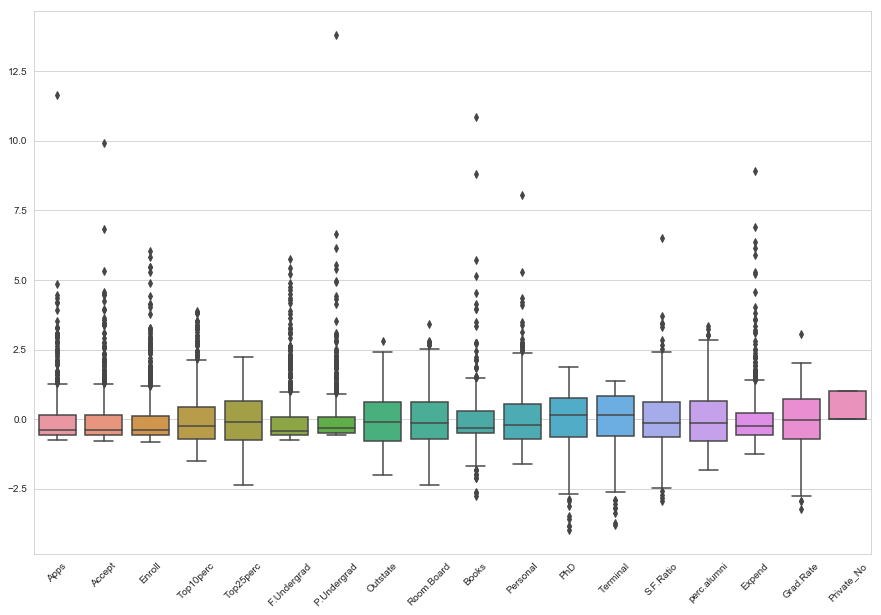

In [188]:
plt.figure(figsize=(15, 10))
plt.xticks(rotation=45)
sns.boxplot(data=data)

## a. Train-test split and Forward Stepwise Selection

After some experimentation, it was noted that the features selected were highly dependent on the train-test split
so we decided to repeat the split many times and look at the most frequently occuring features

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

def is_present_in_fss():
    # train test split default 0.25 test size
    X, y = data.drop(columns=['Outstate', 'Name']), data['Outstate']
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    # FSS for linear regression
    linreg = LinearRegression()
    fss = SequentialFeatureSelector(linreg, k_features='best', scoring='neg_mean_squared_error',
                                cv=7)
    fss.fit(X_train, y_train)
    
    # df with boolean features are present in fss best subset
    return [col in fss.k_feature_names_ for col in data.columns]

def get_fss_results(n_runs=100):
    return pd.DataFrame({i: is_present_in_fss() for i in range(1, n_runs + 1)},
                        index=data.columns).transpose()
    

In [41]:
fss_results = get_fss_results(n_runs=100)

In [122]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Greys
output_notebook()

Loading BokehJS ...

In [127]:
from math import pi

res = fss_results.sum().sort_values(ascending=False)
x_range, counts = list(res.index), list(res)
p = figure(x_range=x_range, title="Frequency of features selected by FSS",
           tools='hover')
p.vbar(x=x_range, top=counts, width=0.5, fill_color='grey', line_color='black')
p.xaxis.major_label_orientation = pi/4
show(p)

We note that `Name` and `Outstate` were never selected (this is by design) while `Room.Board`, `perc.alumni`, `Expend`, `Grad.Rate` and `Private_No` were always selected. 

We reason that, in general, if a feature was selected approximately half the time, its selection by fss was statistically independent of the train-test split. These are the features for which the train test split provides no information.

Thankfully, there are no such features in our case. Our features partition naturally into those selected less than 40% of the time, and those selected greater than 60% of the time. We'll take the latter for our final set of features

## b. GAM for predicting `Outstate` from FSS features

In [194]:
from pygam import LinearGAM, s, f

# train test split on fss features
X, y = data[fss_results.sum()[fss_results.sum() > 60].index], data['Outstate']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# terms for GAM
terms = s(0)
for i in range(1, X_fss.shape[1] - 1):
    terms += s(i)
terms += f(12)

# optimize number of knots and smoothing penalty
n_splines = np.arange(10, 21) 
lams = np.exp(np.random.rand(100, 13) * 6 - 3)
gam = LinearGAM(terms)
gam_search = gam.gridsearch(X_train.values, y_train.values, lam=lams, n_splines=n_splines)

100% (1100 of 1100) |####################| Elapsed Time: 0:02:21 Time:  0:02:21


In [208]:
gam_search.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     51.7716
Link Function:                     IdentityLink Log Likelihood:                                  -975.1374
Number of Samples:                          582 AIC:                                             2055.8181
                                                AICc:                                             2066.562
                                                GCV:                                                0.2227
                                                Scale:                                              0.1874
                                                Pseudo R-Squared:                                   0.8302
Feature Function                  Lam

/anaconda3/envs/islr/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


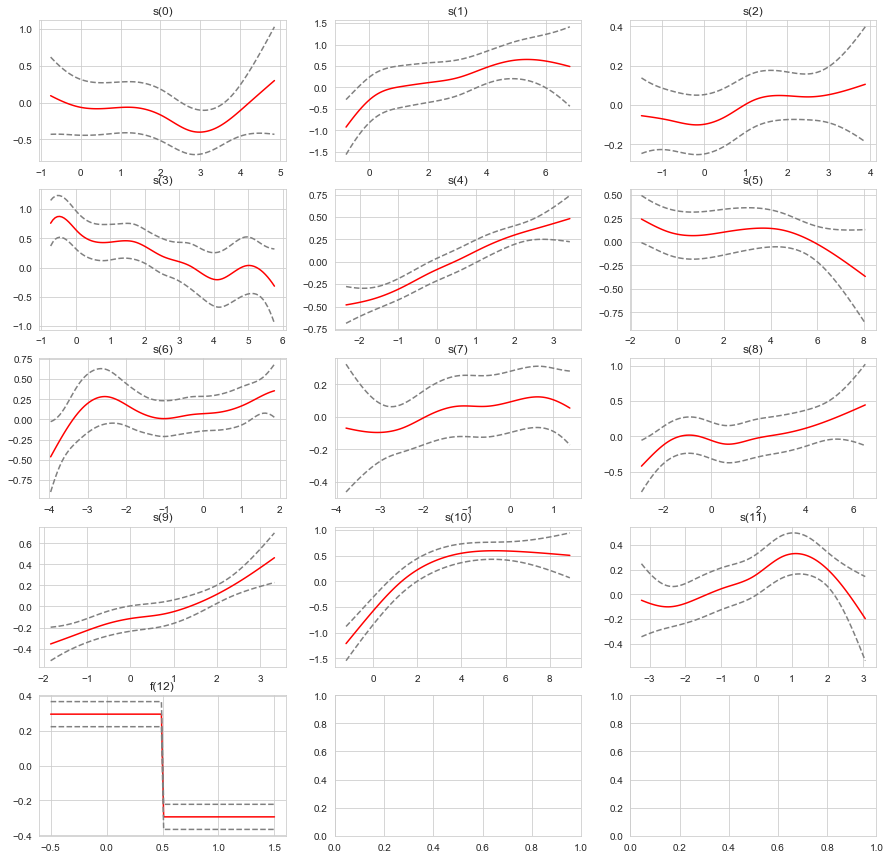

In [238]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15,15))

terms = gam_search.terms[:-1]

for i, term in enumerate(terms):
    XX = gam_search.generate_X_grid(term=i)
    pdep, confi = gam_search.partial_dependence(term=i, X=XX, width=0.95)

    plt.subplot(5, 3, i + 1)
    plt.plot(XX[:, term.feature], pdep, c='r')
    plt.plot(XX[:, term.feature], confi, c='grey', ls='--')
    plt.title(repr(term))
    
plt.show()

## c. Evaluate on test set

In [239]:
from sklearn.metrics import mean_squared_error

# rmse on test data
np.sqrt(mean_squared_error(gam_search.predict(X_test), y_test))

0.5237308479472315

## d. Significant features

In [240]:
# gam for significant features
terms = s(0) + s(1) + s(3) + s(4) + s(8) + s(9) + s(10) + s(11) + f(12)

# optimize number of knots and smoothing penalty
n_splines = np.arange(10, 21) 
lams = np.exp(np.random.rand(100, 9) * 6 - 3)
gam2 = LinearGAM(terms)
gam2_search = gam.gridsearch(X_train.values, y_train.values, lam=lams, n_splines=n_splines)

100% (1100 of 1100) |####################| Elapsed Time: 0:01:24 Time:  0:01:24


In [241]:
gam2_search.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     41.6337
Link Function:                     IdentityLink Log Likelihood:                                 -1003.3785
Number of Samples:                          582 AIC:                                             2092.0243
                                                AICc:                                            2098.9351
                                                GCV:                                                0.2145
                                                Scale:                                              0.1871
                                                Pseudo R-Squared:                                   0.8271
Feature Function                  Lam

/anaconda3/envs/islr/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [242]:
np.sqrt(mean_squared_error(gam2_search.predict(X_test), y_test))

0.495656037843246